In [143]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

# Selective catalytic Reduction

## Thermal model

### Test 1.5

SCR

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

In [145]:
L = 0.5# m
N = 6
dL = L / N
r_in = 0.1 # m
l = np.arange(0, L, dL)

## Določitev prestopa toplote iz izpušnih plinov na steno cevi

In [146]:
rho_EG = 1.2 # kg/m^3
v_EG = 20 # m/s
m_flow = rho_EG * v_EG * math.pi * r_in**2 # kg/s
dt = dL/v_EG # koliko časa potrebuje, da prepotuje dL
DT = L/v_EG
mu_EG = 1.5e-5 # m^2/s
d_in = r_in * 2 # m

Re_EG = rho_EG * v_EG * d_in / mu_EG

cp_EG = 1000 # J/kgK
k_EG = 0.024 # W/mK

Pr_EG = cp_EG * mu_EG / k_EG

print(f"Reynolds number: {Re_EG:.2f}")
print(f"Prandtl number: {Pr_EG:.2f}")

if Re_EG < 2300: # laminar
    alpha_in = 0.664 * Re_EG**0.5 * Pr_EG**(1/3) * k_EG / (d_in)
else:
    alpha_in = 0.023 * Re_EG**(4/5) * Pr_EG**(2/5) * k_EG / (d_in)
alpha_in = alpha_in * 2 # 5x večji koeficient
print(f"alpha_in: {alpha_in:.2f} W/m^2K")
print(f'dt = ', {dt})

Reynolds number: 320000.00
Prandtl number: 0.62
alpha_in: 115.99 W/m^2K
dt =  {0.004166666666666667}


In [147]:
Faktro_zg = 30
A1 = np.array([np.pi * d_in * l[1]]*len(l)) * Faktro_zg #povrsine posameznega kolobarja

In [148]:
# parametri ohišja
r_out = 0.11 # m
d_out = r_out * 2 # m

A2 = np.array([np.pi * d_out * l[1]]*len(l)) * Faktro_zg #povrsine posameznega kolobarja
alpha_out = 10; # W/m^2K

cp_OH = 420 # J/kgK jeklo                           popravi
rho_OH = 7800 # kg/m^3 jeklo
M_OH = rho_OH * math.pi * (r_out**2 - r_in**2) * L # kg
m_OH = M_OH / N # kg/segment

In [149]:
Q1 = np.zeros(len(l-1))         # tok iz zraka skozi steno
Tin = np.zeros(len(l))          # W temperatura znotraj (EG)
Ts = np.zeros(len(l))           # W temperatura stene OH
DeltaT1 = np.zeros(len(l))      # W temperaturna razlika med EG in OH
DeltaT2 = np.zeros(len(l))      # W temperaturna razlika med OH in zrakom
HC1 = np.zeros(len(l))          # W toplotni tok EG skozi SCR
Qout = np.zeros(len(l-1))       # W toplotni tok iz stene OH

# začetni pogoji

Tin[0] = 673 # K
Ts[:] = 293 # K
DeltaT1[0] = Tin[0] - Ts[0]
HC1[0] = m_flow * cp_EG * Tin[0]
T_zraka_ok = 293 # K

for i in range(len(l)-1):
    Q1[i] = alpha_in * A1[i] * DeltaT1[i]
    HC1[i+1] = HC1[i] - Q1[i]
    Tin[i+1] = HC1[i+1] / (m_flow * cp_EG)
    DeltaT1[i+1] = Tin[i+1] - Ts[i+1]
    DeltaT2[i] = Ts[i] - T_zraka_ok
    Qout[i] = alpha_out * A2[i] * DeltaT2[i]


In [150]:
def iteracija(Q1, HC1, DeltaT1, DeltaT2, Qout, Tin, Ts):
    q1 = np.zeros_like(Q1) # tok iz zraka skozi steno
    tin = np.zeros_like(Tin) # W temperatura znotraj (EG)
    ts = np.zeros_like(Ts) # W temperatura stene OH
    deltaT1 = np.zeros_like(DeltaT1) # W temperaturna razlika med EG in OH
    deltaT2 = np.zeros_like(DeltaT2) # W temperaturna razlika med EG in OH
    hc1 = np.zeros_like(HC1) # W toplotni tok EG skozi SCR
    qout = np.zeros_like(Qout) # tok iz zraka iz stene na zrak
    ts = Ts + Q1 * dt/ (m_OH * cp_OH) - Qout * dt / (m_OH * cp_OH)
    deltaT1 = Tin - ts
    deltaT2 = ts - T_zraka_ok
    hc1[0] = m_flow * cp_EG * Tin[0]
    tin[0] = Tin[0]
    
    for i in range(len(l)-1):
        q1[i] = alpha_in * A1[i] * deltaT1[i]
        hc1[i+1] = hc1[i] - q1[i]
        tin[i+1] = hc1[i+1] / (m_flow * cp_EG)
        deltaT1[i+1] = tin[i+1] - ts[i+1]
        qout[i] = alpha_out * A2[i] * deltaT2[i]
    
    return q1, tin, ts, deltaT1, hc1, qout, deltaT2

Tole spodnjo celico dolgo računa, a brez strahu. Za vsako točko SCRa mora za vsak "prelet izračunat temperaturni profilEG in ohišja, prav tako toplotne tokove.

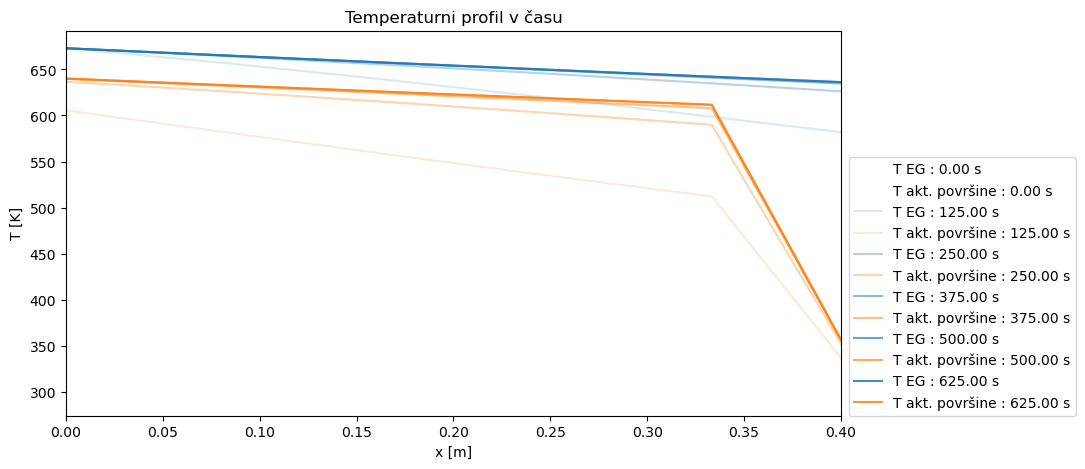

In [151]:
Q1 = np.zeros(len(l-1))         # tok iz zraka skozi steno
Tin = np.zeros(len(l))          # W temperatura znotraj (EG)
Ts = np.zeros(len(l))           # W temperatura stene OH
DeltaT1 = np.zeros(len(l))      # W temperaturna razlika med EG in OH
HC1 = np.zeros(len(l))          # W toplotni tok EG skozi SCR
Qout = np.zeros(len(l-1))       # W toplotni tok iz stene OH
DeltaT2 = np.zeros(len(l))      # W temperaturna razlika med EG in OH

# začetni pogoji
Tin[0] = 673 # K
Ts[:] = 293 # K
DeltaT1[0] = Tin[0] - Ts[0]
HC1[0] = m_flow * cp_EG * Tin[0]

for i in range(len(l)-1):
    Q1[i] = alpha_in * A1[i] * DeltaT1[i]
    Qout[i] = alpha_out * A2[i] * DeltaT2[i] # alfa je 20 in t Zraka je
    HC1[i+1] = HC1[i] - Q1[i]
    Tin[i+1] = HC1[i+1] / (m_flow * cp_EG)
    DeltaT1[i+1] = Tin[i+1] - Ts[i+1]

# print(Tin)

q1, tin, ts, deltaT1, hc1 , qout, deltaT2 = iteracija(Q1, HC1, DeltaT1, DeltaT2, Qout, Tin, Ts)

Q1 = np.vstack((Q1, q1))
Tin = np.vstack((Tin, tin))
Ts = np.vstack((Ts, ts))
DeltaT1 = np.vstack((DeltaT1, deltaT1))
HC1 = np.vstack((HC1, hc1))
Qout = np.vstack((Qout, qout))
DeltaT2 = np.vstack((DeltaT2, deltaT2))

fig, ax = plt.subplots(figsize=(10, 5))
št_it = 30000
for i in np.arange(št_it):
    q1, tin, ts, deltaT1, hc1 , qout, deltaT2 = iteracija(Q1[-1], HC1[-1], DeltaT1[-1], DeltaT2[-1], Qout[-1], Tin[-1], Ts[-1])
    Q1 = np.vstack((Q1, q1))
    Tin = np.vstack((Tin, tin))
    Ts = np.vstack((Ts, ts))
    DeltaT1 = np.vstack((DeltaT1, deltaT1))
    HC1 = np.vstack((HC1, hc1))
    Qout = np.vstack((Qout, qout))
    DeltaT2 = np.vstack((DeltaT2, deltaT2))
    if i % 5000 == 0:
        ax.plot(l, Tin[-1], c='C0', alpha= i/30000, label=f"T EG : {i*DT:.2f} s")
        ax.plot(l, Ts[-1], c='C1', alpha= i/30000, label=f"T akt. površine : {i*DT:.2f} s")
ax.set_xlim(0, 0.4)
ax.set_title(f'Temperaturni profil v času')
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend(loc=(1.01, 0))

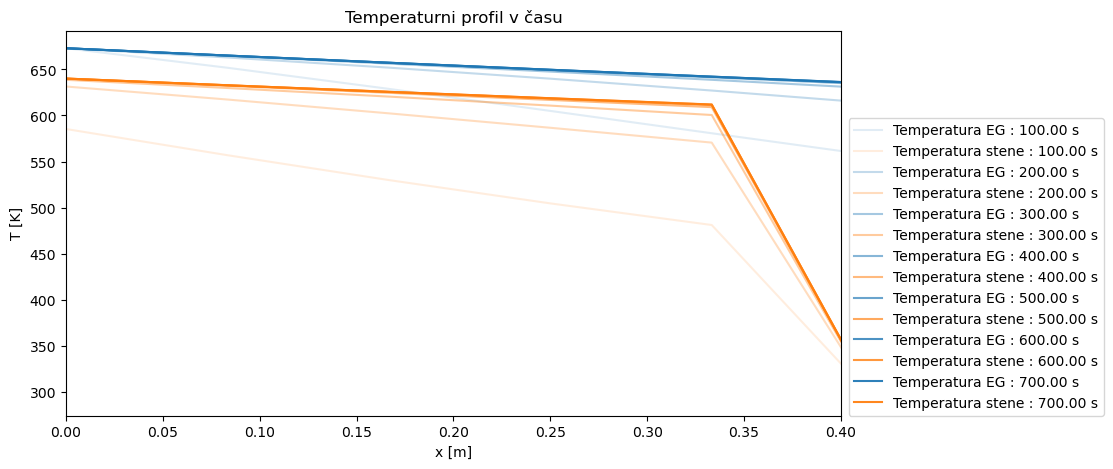

In [152]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in np.arange(št_it)[1:]:
    if i % 4000 == 0:
        ax.plot(l, Tin[i], c='C0', alpha= i/30000, label=f"Temperatura EG : {i*DT:.2f} s")
        ax.plot(l, Ts[i], c='C1', alpha= i/30000, label=f"Temperatura stene : {i*DT:.2f} s")
ax.set_xlim(0, 0.4)
ax.set_title(f'Temperaturni profil v času')
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.legend(loc=(1.01, 0))


In [153]:
print(f'Temperature zraka na vhodu v vsaki iteraciji {Tin[:, 0][:5]}. Mora biti enako!')

Temperature zraka na vhodu v vsaki iteraciji [673. 673. 673. 673. 673.]. Mora biti enako!


## Temperaturni profili po 20, 100, 300 s

Po 20 $s$

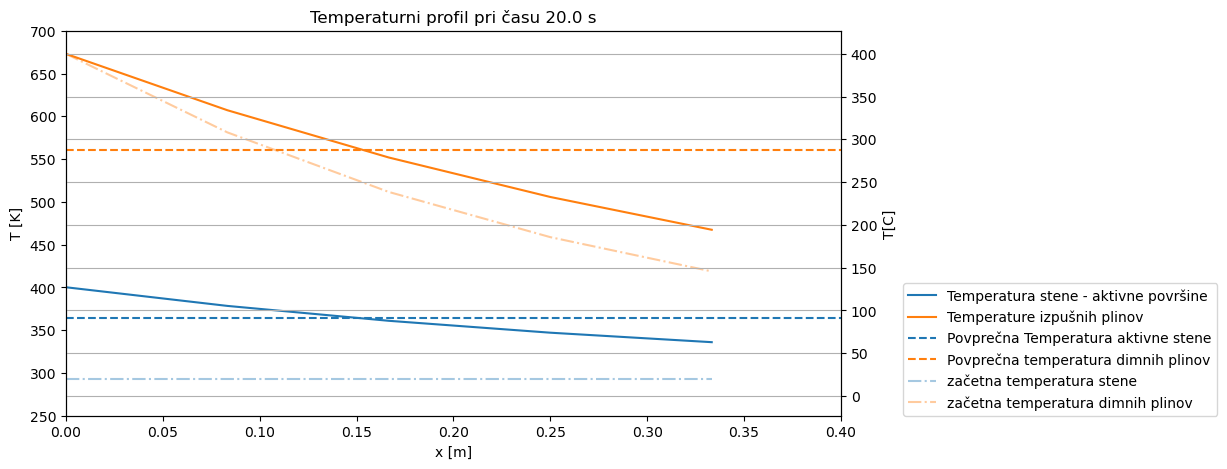

In [154]:
sek = 20 # pri kateri sekundi nas zanima
fig, ax = plt.subplots(figsize=(10, 5))
i = 40*sek
ax.set_title(f'Temperaturni profil pri času {DT*i} s')
ax.plot(l[:-1], Ts[i][:-1], label="Temperatura stene - aktivne površine")
ax.plot(l[:-1], Tin[i][:-1], label="Temperature izpušnih plinov")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.hlines(np.mean(Ts[i][:-1]), 0, 1, color="C0", linestyles='dashed', label='Povprečna Temperatura aktivne stene')
ax.hlines(np.mean(Tin[i][:-1]), 0, 1, color="C1", linestyles='dashed', label='Povprečna temperatura dimnih plinov')
# začetna linija
ax.plot(l[:-1], Ts[0][:-1], '-.', color="C0", alpha=0.4, label='začetna temperatura stene')
ax.plot(l[:-1], Tin[0][:-1], '-.', color="C1", alpha=0.4, label='začetna temperatura dimnih plinov')

ax.set_xlim(0, 0.4)
ax.set_ylim(250, 700)
ax.legend(loc=(1.08, 0))

ax2 = ax.twinx()
ax2.set_ylabel('T[C]');
ax2.set_ylim(250-273, 700-273)
# ax.grid()
ax2.grid()
fig.savefig(f'slike/T_Profil_po_{sek}_s.jpg', dpi=300, bbox_inches='tight')

Po 100 $s$

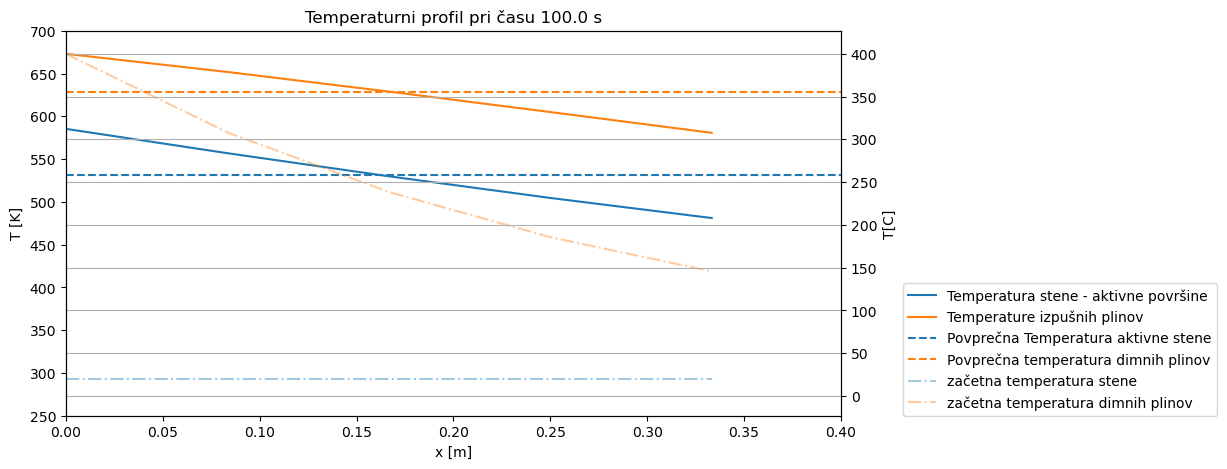

In [155]:
sek = 100 # pri kateri sekundi nas zanima
fig, ax = plt.subplots(figsize=(10, 5))
i = 40*sek
ax.set_title(f'Temperaturni profil pri času {DT*i} s')
ax.plot(l[:-1], Ts[i][:-1], label="Temperatura stene - aktivne površine")
ax.plot(l[:-1], Tin[i][:-1], label="Temperature izpušnih plinov")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.hlines(np.mean(Ts[i][:-1]), 0, 1, color="C0", linestyles='dashed', label='Povprečna Temperatura aktivne stene')
ax.hlines(np.mean(Tin[i][:-1]), 0, 1, color="C1", linestyles='dashed', label='Povprečna temperatura dimnih plinov')
# začetna linija
ax.plot(l[:-1], Ts[0][:-1], '-.', color="C0", alpha=0.4, label='začetna temperatura stene')
ax.plot(l[:-1], Tin[0][:-1], '-.', color="C1", alpha=0.4, label='začetna temperatura dimnih plinov')

ax.set_xlim(0, 0.4)
ax.set_ylim(250, 700)
ax.legend(loc=(1.08, 0))

ax2 = ax.twinx()
ax2.set_ylabel('T[C]');
ax2.set_ylim(250-273, 700-273)
# ax.grid()
ax2.grid()
fig.savefig(f'slike/T_Profil_po_{sek}_s.jpg', dpi=300, bbox_inches='tight')

Po 300 $s$

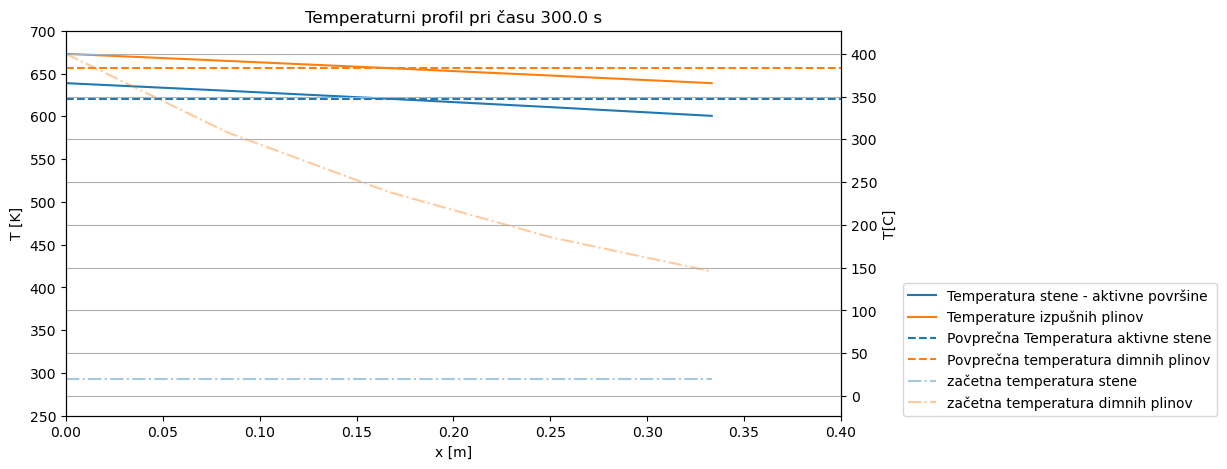

In [156]:
sek = 300 # pri kateri sekundi nas zanima
fig, ax = plt.subplots(figsize=(10, 5))
i = 40*sek
ax.set_title(f'Temperaturni profil pri času {DT*i} s')
ax.plot(l[:-1], Ts[i][:-1], label="Temperatura stene - aktivne površine")
ax.plot(l[:-1], Tin[i][:-1], label="Temperature izpušnih plinov")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.hlines(np.mean(Ts[i][:-1]), 0, 1, color="C0", linestyles='dashed', label='Povprečna Temperatura aktivne stene')
ax.hlines(np.mean(Tin[i][:-1]), 0, 1, color="C1", linestyles='dashed', label='Povprečna temperatura dimnih plinov')
# začetna linija
ax.plot(l[:-1], Ts[0][:-1], '-.', color="C0", alpha=0.4, label='začetna temperatura stene')
ax.plot(l[:-1], Tin[0][:-1], '-.', color="C1", alpha=0.4, label='začetna temperatura dimnih plinov')

ax.set_xlim(0, 0.4)
ax.set_ylim(250, 700)
ax.legend(loc=(1.08, 0))

ax2 = ax.twinx()
ax2.set_ylabel('T[C]');
ax2.set_ylim(250-273, 700-273)
# ax.grid()
ax2.grid()
fig.savefig(f'slike/T_Profil_po_{sek}_s.jpg', dpi=300, bbox_inches='tight')

In [157]:
# Shranimo povprečne rednosti za vsako iteracijo v array
T_notr_povp = np.zeros(len(Ts))
for i in range(len(Ts)):
    T_notr_povp[i] = np.mean(Ts[i])

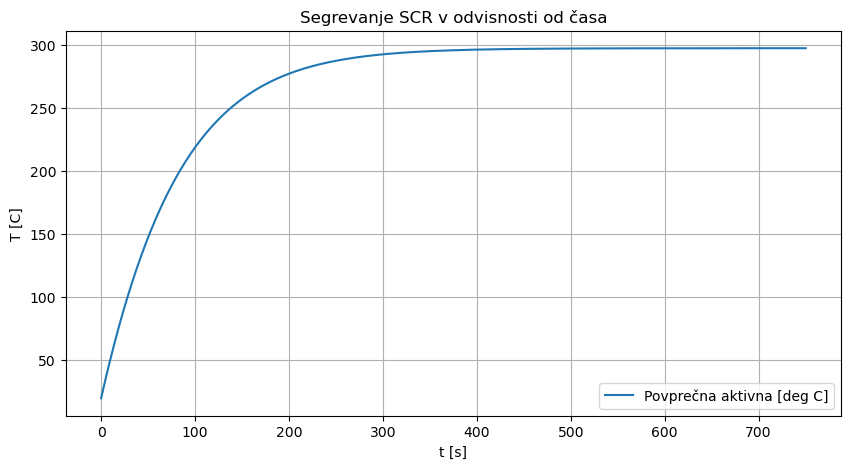

In [158]:
čas = np.arange(0, len(T_notr_povp), 1)*DT
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Segrevanje SCR v odvisnosti od časa')
ax.plot(čas, T_notr_povp-273, label="Povprečna aktivna [deg C]")
ax.set_ylabel("T [C]")
ax.set_xlabel("t [s]")
ax.legend(loc="lower right")
ax.grid()

Spreminjanje temperature aktivne površine skozi čas in po dolžini

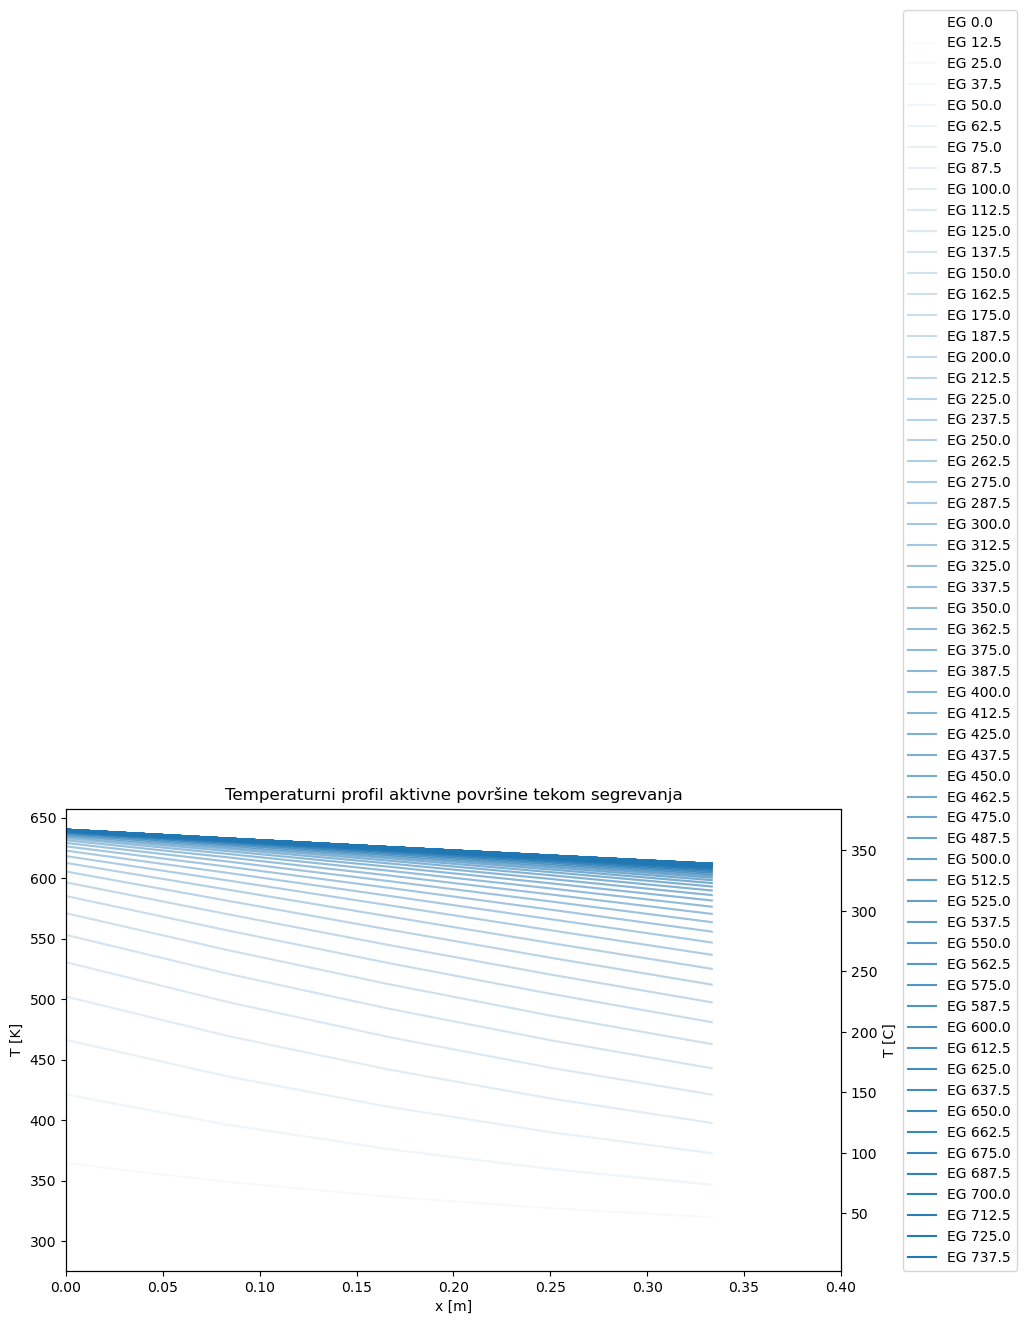

In [159]:
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()

for i in np.arange(0, št_it, 500):
    ax.plot(l[:-1], Ts[i][:-1], c="C0", alpha=1/št_it*i, label=f"EG {i*DT}")
    ax2.plot(l[:-1], Ts[i][:-1]-273, c="C0", alpha=1/št_it*i, label=f"EG")
ax.set_title("Temperaturni profil aktivne površine tekom segrevanja")
ax.set_xlim(0, 0.4)
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax2.set_ylabel("T [C]")
ax.legend(loc=(1.08, 0))

Text(0, 0.5, 'T [C]')

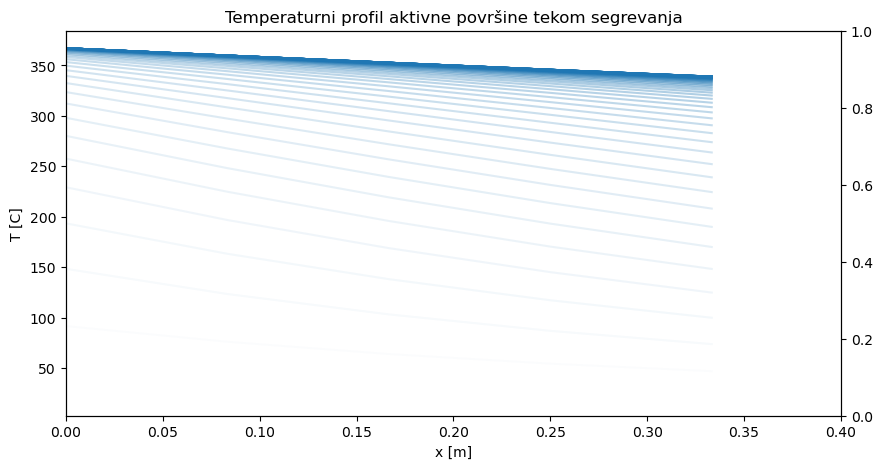

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

for i in np.arange(0, št_it, 500):
    ax.plot(l[:-1], Ts[i][:-1]-273, c="C0", alpha=1/št_it*i, label=f"EG")
    # ax.plot(l[:-1], Tin[i][:-1], c="C1", alpha=1/1000*i, label="OH")
ax.set_title("Temperaturni profil aktivne površine tekom segrevanja")
ax.set_xlim(0, 0.4)
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")

## Kemijski del

In [161]:
# print(f'Volumski pretok: {m_flow:.2f} kg/s')

# Define the total volume flow rate and velocity of the exhaust gases
# Q = 100.0  # Total volume flow rate in m^3/s
V = v_EG  # Velocity in m/s
Q = v_EG * math.pi * r_in**2

# Define the molar fractions or volume percentages of each component
molar_fractions = {
    'NO': 0.05,
    'NO2': 0.1,
    'CO2': 0.3,
    'O2': 0.1,
    'CO': 0.1,
    'H2O': 0.25,
    'N2': 0.1
}

# Calculate the molar flow rate of the exhaust gases
n = Q / V

# Calculate the moles of each component
moles = {component: molar_fractions[component] * n for component in molar_fractions}

# Define the molar masses of each component in kg/mol
molar_masses = {
    'NO': 30.0,
    'NO2': 46.0,
    'CO2': 44.0,
    'O2': 32.0,
    'CO': 28.0,
    'H2O': 18.0,
    'N2': 28.0
}

# Calculate the mass of each component
masses = {component: moles[component] * molar_masses[component] for component in moles}

# Calculate the total mass of the exhaust gases
m_total = sum(masses.values())

# Calculate the mass percentage of each component
mass_percentages = {component: (masses[component] / m_total) * 100.0 for component in masses}

# Print the mass percentages
print(f'\tMasni deleži \t Molski deleži')
for component, mass_percentage in mass_percentages.items():
    print(f"{component}: \t {mass_percentage:.3f}%, \t {molar_fractions[component]*100:.3f}%")


	Masni deleži 	 Molski deleži
NO: 	 4.601%, 	 5.000%
NO2: 	 14.110%, 	 10.000%
CO2: 	 40.491%, 	 30.000%
O2: 	 9.816%, 	 10.000%
CO: 	 8.589%, 	 10.000%
H2O: 	 13.804%, 	 25.000%
N2: 	 8.589%, 	 10.000%


TypeError: float() argument must be a string or a number, not 'dict_values'

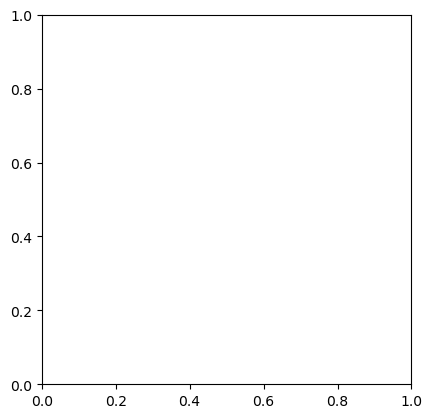

In [162]:
fig, ax = plt.subplots()
values = np.array([mass_percentages.values()])
labels = np.array([mass_percentages.keys()])
ax.pie(values, labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures a circular cake diagram

In [ ]:
# 4NH3 + 4NO + O2 -> 4N2 + 6H2O
# 4NH3 + 2NO + 2O2 -> 4N2 + 6H2O
# 8NH3 + 6NO2 -> 7N2 + 12H2O


# 2/3 NO gre v prvo reakcijo
# 1/4 NO2 gre v drugo reakcijo
# 3/4 NO2 gre v tretjo reakcijo

Q # m3/s

0.6283185307179587

In [ ]:
# Given parameters
volume_flow_rate = Q  # m^3/s
pressure = 100000  # Pa 1bar
temperature = Tin[-1][0]  # K
gas_constant = 8.314  # J/(mol*K)

# Calculate the total number of moles using the ideal gas law
total_moles = (volume_flow_rate * pressure) / (gas_constant * temperature)

# Given molar fractions
molar_fractions = {
    'NO': 0.05,
    'NO2': 0.1,
    'CO2': 0.3,
    'O2': 0.1,
    'CO': 0.1,
    'H2O': 0.25,
    'N2': 0.1
}

N_A = 6.02214076e23  # Avogadro's number
# Calculate the number of moles for each component based on the molar fractions
moles = {key: molar_fractions[key] * N_A * total_moles for key in molar_fractions}

# Print the number of moles for each component
for key, value in moles.items():
    print(f"Nr moles  {key}: {(value/1000000000000000):.3f} e15")


Nr moles  NO: 455114581.922 e15
Nr moles  NO2: 910229163.844 e15
Nr moles  CO2: 2730687491.532 e15
Nr moles  O2: 910229163.844 e15
Nr moles  CO: 910229163.844 e15
Nr moles  H2O: 2275572909.610 e15
Nr moles  N2: 910229163.844 e15


In [ ]:
moles

{'NO': 4.551145819220509e+23,
 'NO2': 9.102291638441018e+23,
 'CO2': 2.7306874915323056e+24,
 'O2': 9.102291638441018e+23,
 'CO': 9.102291638441018e+23,
 'H2O': 2.2755729096102545e+24,
 'N2': 9.102291638441018e+23}

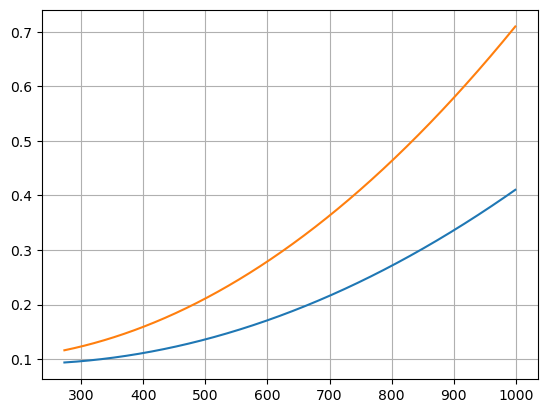

In [ ]:
Temp_vse = np.arange(273, 1000, 1)
verjetnost_NO2 = 0.0000008 * Temp_vse**2 - 0.0002 * Temp_vse + 0.1112
verjetnost_NO = 0.0000005 * Temp_vse**2 - 0.0002 * Temp_vse + 0.1112
plt.plot(Temp_vse, verjetnost_NO)
plt.plot(Temp_vse, verjetnost_NO2)
plt.grid()

In [ ]:
def Konverzija(moles, T):
    moles2 = moles.copy()
    r = moles['NO']/moles['NO2']
    

Razmerje NO/NO2: 0.500


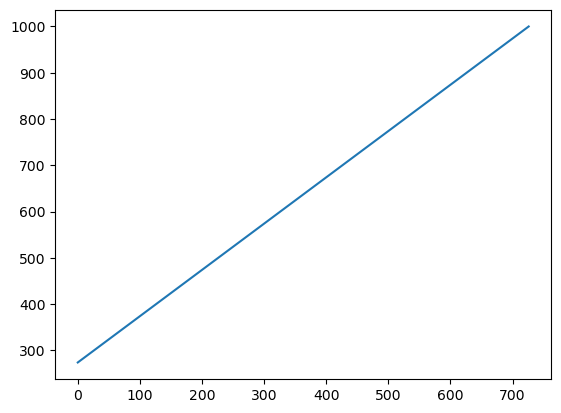

In [ ]:
r = moles['NO']/moles['NO2']
print(f"Razmerje NO/NO2: {r:.3f}")
k = -(r+0.5)*(r-1.5) * Temp_vse+1
plt.plot(k)

In [ ]:
def Reakcije3(moles, Temperatura):
    '''Temperatura v K'''
    moles2 = moles.copy()
    
    # R1
    moles2['NO'] = 2/3 * moles['NO'] * verjetnost_NO[Temperatura]
    moles2['H20'] = moles['H20'] + 3/2 * moles['NO']
    moles2['N2'] = moles['N2'] + moles['NO']
    moles2['O2'] = moles['O2'] * 1/4 * moles['NO']
    moles2['CO2'] = moles['CO2']
    moles2['CO'] = moles['CO']
    
    # R2
    moles2['NO2'] = 1/4 * moles['NO2'] * verjetnost_NO2[Temperatura]
    moles2['NO'] = moles2['NO'] - 1/3 * moles['NO'] * verjetnost_NO2[Temperatura]
    